## Henon Heiles: Reversible SympNets

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math as mt
from tensorflow import keras
from tensorflow.keras import layers
import time
import wandb
from matplotlib import rc

### Import Training Dataset

In [2]:
file = open("x_train_HH_E01667.txt", "r")
line_count = 0
for line in file:
    if line != "\n":
        line_count += 1
file.close()

Ty = []
Tydot = []

read_y = open("x_train_HH_E01667.txt", "r")
read_ydot = open("y_train_HH_E01667.txt", "r")


for i in range(line_count):
    Ty.append(float(read_y.readline()))
    Tydot.append(float(read_ydot.readline()))

read_y.close()
read_ydot.close()

print("Number of points: ", len(Ty))

Number of points:  146719


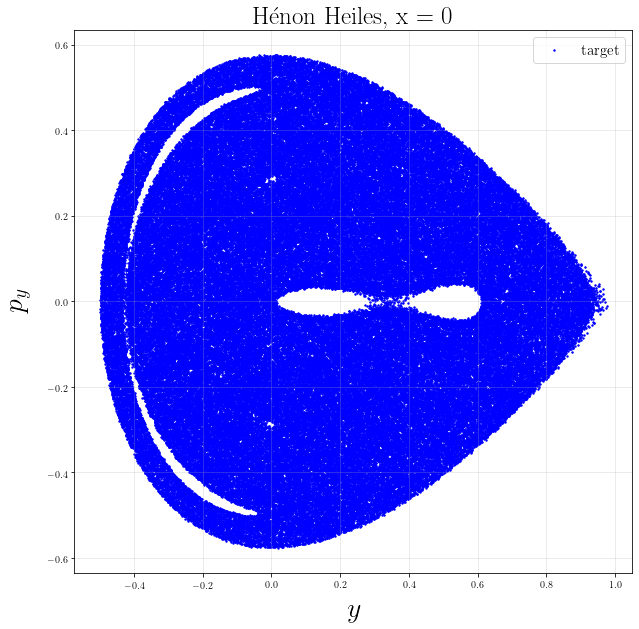

In [3]:
plt.figure(figsize=(10,10))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'H\'enon Heiles, x = 0', fontsize = 25)
plt.scatter(Ty,Tydot, color = 'b', label = 'target', linewidth = 1, s=2)
plt.xlabel(r'$y$', fontsize=28, labelpad=8)
plt.ylabel(r'$p_{y}$', fontsize=28, labelpad=15)
plt.grid(axis='both', alpha=.3)
plt.legend(fontsize = 15, loc = 'upper right')
plt.show()

### Training Dataset

In [4]:
X_train = [np.array([Ty[i],Tydot[i]]) for i in range(len(Ty)-1)]
Y_train = [np.array([Ty[i],Tydot[i]]) for i in range(1,len(Ty))]

In [5]:
# TRAINING SET

x_train = np.array(X_train)
x_train = x_train.astype(np.float32)

y_train = np.array(Y_train)
y_train = y_train.astype(np.float32)


x_val = x_train[-10000:]
y_val = y_train[-10000:]

x_train = x_train[:-10000]
y_train = y_train[:-10000]

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(10000)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.batch(10000)

train_dataset.element_spec

(TensorSpec(shape=(None, 2), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))

----------------------------------------------------
----------------------------------------------------
----------------------------------------------------

### Custom Layers

In [6]:
class linear_module_up(layers.Layer):
    
    def __init__(self):
        
        super().__init__()
        self.w = self.add_weight(
        name='w',
        shape=(1,),
        initializer = 'random_normal',
        trainable = True
        )
    

    def call(self, x, inverse):
        
        if inverse == 0:
        
            L = tf.concat([[[1., self.w[0]]],[[0., 1.]]], 0)
            return tf.linalg.matvec(L, x)
        
        else:
            
            L = tf.concat([[[1., -self.w[0]]],[[0., 1.]]], 0)
            return tf.linalg.matvec(L, x)


class linear_module_low(layers.Layer):
    
    def __init__(self):
        
        super().__init__()
        self.w = self.add_weight(
        name='w',
        shape=(1,),
        initializer = 'random_normal',
        trainable = True
        )

    def call(self, x, inverse):

        if inverse == 0:

                L = tf.concat([[[1., 0.]],[[self.w[0], 1.]]], 0)
                return tf.linalg.matvec(L,x)
        else:

                L = tf.concat([[[1., 0.]],[[-self.w[0], 1.]]], 0)
                return tf.linalg.matvec(L,x)



class bias(layers.Layer):
    
    def __init__(self):

        super().__init__()
        self.b = self.add_weight(
        name='b',
        shape=(2,),
        initializer = 'random_normal',
        trainable = True
        )

    def call(self, x, inverse):

        if inverse == 0:

                return x + self.b
        else:

                return x - self.b


            
class activation_module_up(layers.Layer):
    
    def __init__(self):
        
        super().__init__()
        self.w = self.add_weight(
        name='w',
        shape=(1,),
        initializer = 'random_normal',
        trainable = True
        )


    def call(self, x, inverse):
        
        if inverse == 0:
            
            t = tf.concat([[[0., self.w[0]]], [[0.,0.]]], 0)
            return x + tf.linalg.matvec(t, tf.math.tanh(x))

        else:
            
            t = tf.concat([[[0., -self.w[0]]], [[0.,0.]]], 0)
            return x + tf.linalg.matvec(t, tf.math.tanh(x))

class activation_module_low(layers.Layer):
    
    def __init__(self):
        
        super().__init__()
        self.w = self.add_weight(
        name='w',
        shape=(1,),
        initializer = 'random_normal',
        trainable = True
        )


    def call(self, x, inverse):
        
        if inverse == 0:

            t = tf.concat([[[0., 0.]], [[self.w[0], 0.]]], 0)        
            return x + tf.linalg.matvec(t, tf.math.tanh(x))
        
        else: 
            
            t = tf.concat([[[0., 0.]], [[-self.w[0], 0.]]], 0)        
            return x + tf.linalg.matvec(t, tf.math.tanh(x))

### SympNet

In [7]:
class SympNet(keras.Model):
    
    def __init__(self, N_layers, N_sub):
        
        super().__init__()
        
        
        self.Modules = []
        
        for i in range(N_layers):
            
            if i%2==0:
                self.Modules.append(activation_module_up())
                
            else:
                self.Modules.append(activation_module_low())
                
            for j in range(N_sub):
                
                if j==0:
                    self.Modules.append(bias())
                
                if j%2==0:
                    self.Modules.append(linear_module_up())

                else:
                    self.Modules.append(linear_module_low())
        
        

    def call(self, input_tensor):
        
        boom = self.Modules[0](input_tensor, 0)
        
        for i in range(1,len(self.Modules)):
            boom = self.Modules[i](boom, 0)
        
        boom = boom*tf.constant([1., -1.])        
        
        for i in range(1, len(self.Modules)):
            boom = self.Modules[-i](boom, 1)
        
        boom = self.Modules[0](boom, 1)*tf.constant([1., -1.])
    
        return boom

### Training

In [8]:
model = SympNet(25, 5)

In [9]:
# DECAYING LEARNING RATE

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr*tf.math.exp(-0.001)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [10]:
model.compile(
    loss= tf.keras.losses.MeanSquaredError(),
    #optimizer=tfps.optimizers.bfgs_minimize(), #clipvalue = 0.001),
    #optimizer=keras.optimizers.SGD(0.00001), #, clipvalue = 0.001),
    optimizer=keras.optimizers.Adam(0.001), #, clipvalue = 0.001),
    metrics=["accuracy"],
)

In [11]:
#wandb.init()
start_time = time.time()
history = model.fit(train_dataset, epochs = 10, validation_data=val_dataset, callbacks=[callback], verbose=1)
print("running time : %s seconds" % (time.time() - start_time))

Epoch 1/10
14/14 [==============================] - 10s 722ms/step - loss: 0.1673 - accuracy: 0.5928 - val_loss: 0.1290 - val_accuracy: 0.6839
Epoch 2/10
14/14 [==============================] - 7s 469ms/step - loss: 0.1250 - accuracy: 0.6859 - val_loss: 0.1351 - val_accuracy: 0.7404
Epoch 3/10
14/14 [==============================] - 7s 486ms/step - loss: 0.1229 - accuracy: 0.7096 - val_loss: 0.1281 - val_accuracy: 0.7332
Epoch 4/10
14/14 [==============================] - 7s 487ms/step - loss: 0.1201 - accuracy: 0.6969 - val_loss: 0.1256 - val_accuracy: 0.7265
Epoch 5/10
14/14 [==============================] - 7s 475ms/step - loss: 0.1177 - accuracy: 0.6913 - val_loss: 0.1215 - val_accuracy: 0.7306
Epoch 6/10
14/14 [==============================] - 7s 473ms/step - loss: 0.1131 - accuracy: 0.7003 - val_loss: 0.1142 - val_accuracy: 0.7439
Epoch 7/10
14/14 [==============================] - 7s 476ms/step - loss: 0.1056 - accuracy: 0.7181 - val_loss: 0.1055 - val_accuracy: 0.7625
Epoch

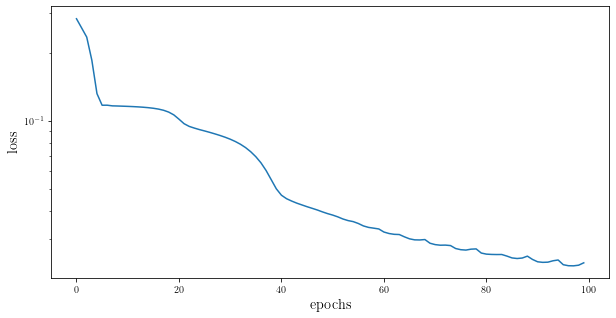

In [19]:
plt.figure(figsize = (10,5))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.plot(history.history["loss"])
plt.title("SympNet", fontsize=30)
plt.xlabel(r'epochs', fontsize=20)
plt.ylabel(r'loss', fontsize=20)
plt.yscale("log")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
#plt.savefig("loss_SympNet_E01667")

## Tests

In [ ]:
plt.figure(figsize=(10,10))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'SympNet', fontsize = 30)

x = model(tf.constant([[Ty[0], Tydot[0]]]))
xx = [x[0][0].numpy()]
yy = [x[0][1].numpy()]


for i in range(2):
    x = model(x)
    xx.append(x[0][0].numpy())
    yy.append(x[0][1].numpy())

plt.plot(xx, yy, color='r')

plt.scatter(xx[-1], yy[-1], label=r'$\mathcal{T}^{2}(x,y)$', marker = 'o', color='r', s=35)
plt.scatter(xx[-1], -yy[-1], label=r'$R\mathcal{T}^{2}(x,y)$', marker = 'o', color='b', s=35)


x = model(tf.constant([[xx[-1], -yy[-1]]]))
xx = [xx[-1]]
yy = [-yy[-1]]
xx.append(x[0][0].numpy())
yy.append(x[0][1].numpy())

for i in range(2):
    x = model(x)
    xx.append(x[0][0].numpy())
    yy.append(x[0][1].numpy())

plt.plot(xx,yy, color='b')
plt.xlabel(r'$y$', fontsize=28, labelpad=8)
plt.ylabel(r'$p_{y}$', fontsize=28, labelpad=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
plt.legend(fontsize = 25, loc = 'upper left')
plt.savefig("non_reversible_E01667")
plt.show()

In [20]:
test = model(x_train)

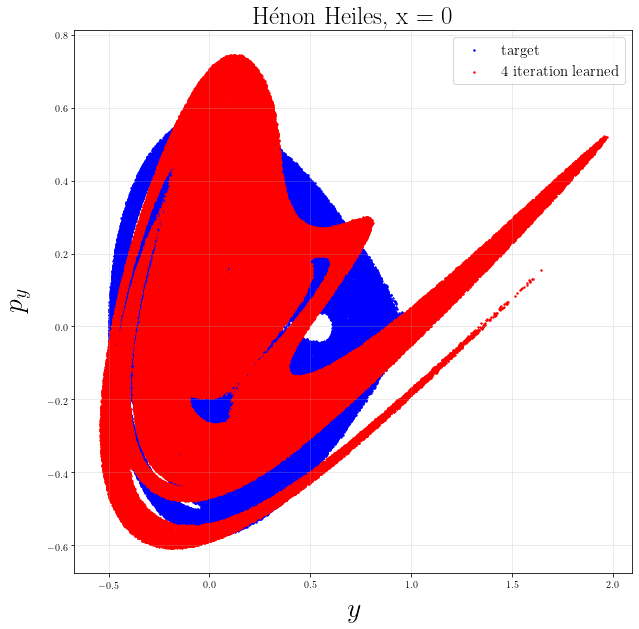

In [21]:
plt.figure(figsize=(10,10))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'SympNet', fontsize = 30)
plt.scatter(Ty,Tydot, color = "b", label = r'target, $x$', linewidth = 1, s=2)
plt.scatter([test[i][0].numpy() for i in range(len(x_train))], [test[i][1].numpy() for i in range(len(x_train))], color = "r", label = r'$\mathcal{T}^{2}(x)$, learned', linewidth = 1, s=2)
plt.xlabel(r'$y$', fontsize=28, labelpad=8)
plt.ylabel(r'$p_{y}$', fontsize=28, labelpad=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
plt.legend(fontsize = 25, loc = 'upper right')
#plt.savefig("Iterations_SympNet_E01667")
plt.show()